In [45]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/age-gender-and-ethnicity-face-data-csv/age_gender.csv


# Import necessary libraries

In [46]:
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import keras
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten
import kerastuner as kt

# Read and preprocessing data

**"img_name" column is dropped because we do not need it.**


In [47]:
mydata= pd.read_csv("../input/age-gender-and-ethnicity-face-data-csv/age_gender.csv")
mydata.drop("img_name",axis=1, inplace= True)
mydata.head(10)

,age,ethnicity,gender,pixels
0,1,2,0,129 128 128 126 127 130 133 135 139 142 145 14...
1,1,2,0,164 74 111 168 169 171 175 182 184 188 193 199...
2,1,2,0,67 70 71 70 69 67 70 79 90 103 116 132 145 155...
3,1,2,0,193 197 198 200 199 200 202 203 204 205 208 21...
4,1,2,0,202 205 209 210 209 209 210 211 212 214 218 21...
5,1,2,0,195 198 200 200 198 198 199 199 198 197 197 19...
6,1,2,0,208 216 217 219 222 223 222 221 220 220 221 22...
7,1,2,0,99 142 169 177 179 181 183 186 187 186 191 190...
8,1,2,0,127 127 133 140 143 148 152 157 160 165 172 17...
9,1,2,0,199 211 211 214 216 216 219 221 222 224 219 21...


# Visualisation for analysing the data

### Gender data

<AxesSubplot:xlabel='gender', ylabel='count'>

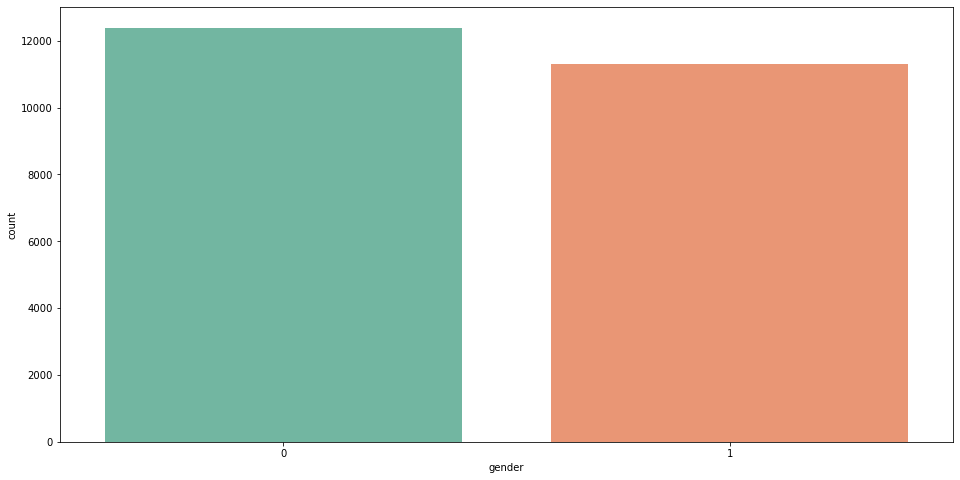

In [48]:
plt.figure(figsize=(16,8))
sns.set_palette("Set2")
sns.countplot(x ='gender', data = mydata) 

As you see, they are almost equal, so we do not need to preprocess for the data which is gender. On the chart, "0" is labelled for man and "1" is labelled for woman.

### Ethnicity data

<AxesSubplot:xlabel='ethnicity', ylabel='count'>

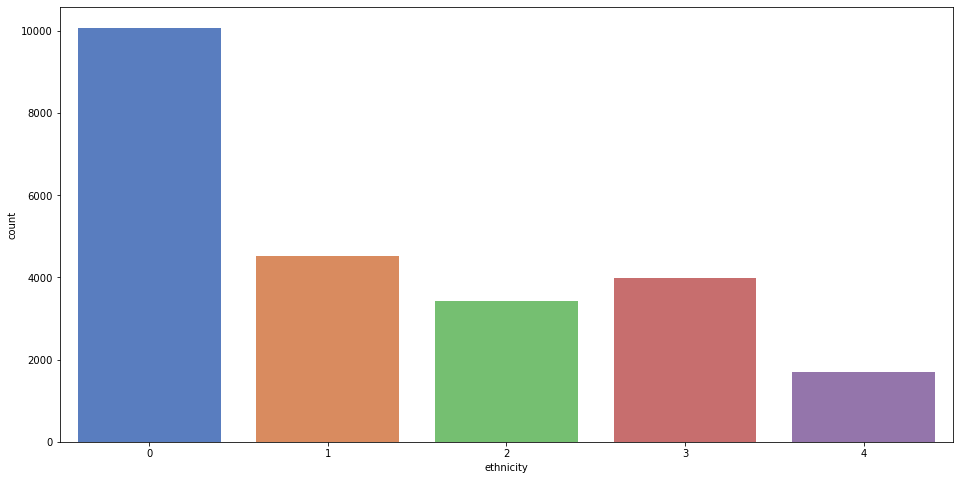

In [49]:
plt.figure(figsize=(16,8))
sns.set_palette("muted")
sns.countplot(x ='ethnicity', data = mydata) 

As you see, there are some problems. Ethnicity with label "0" is too much if we look other labelled ethnicity. Also, Ethnicity with label "4" is very little. We should preprocess the data.

In [50]:
count_eth=mydata[mydata["ethnicity"]==4]["ethnicity"].count()
len_eth=len(mydata["ethnicity"])
print("There are {} labelled data for ethnicity 4 and length of ethnicity data is {}".format(count_eth,len_eth))

There are 1692 labelled data for ethnicity 4 and length of ethnicity data is 23705


### Age data

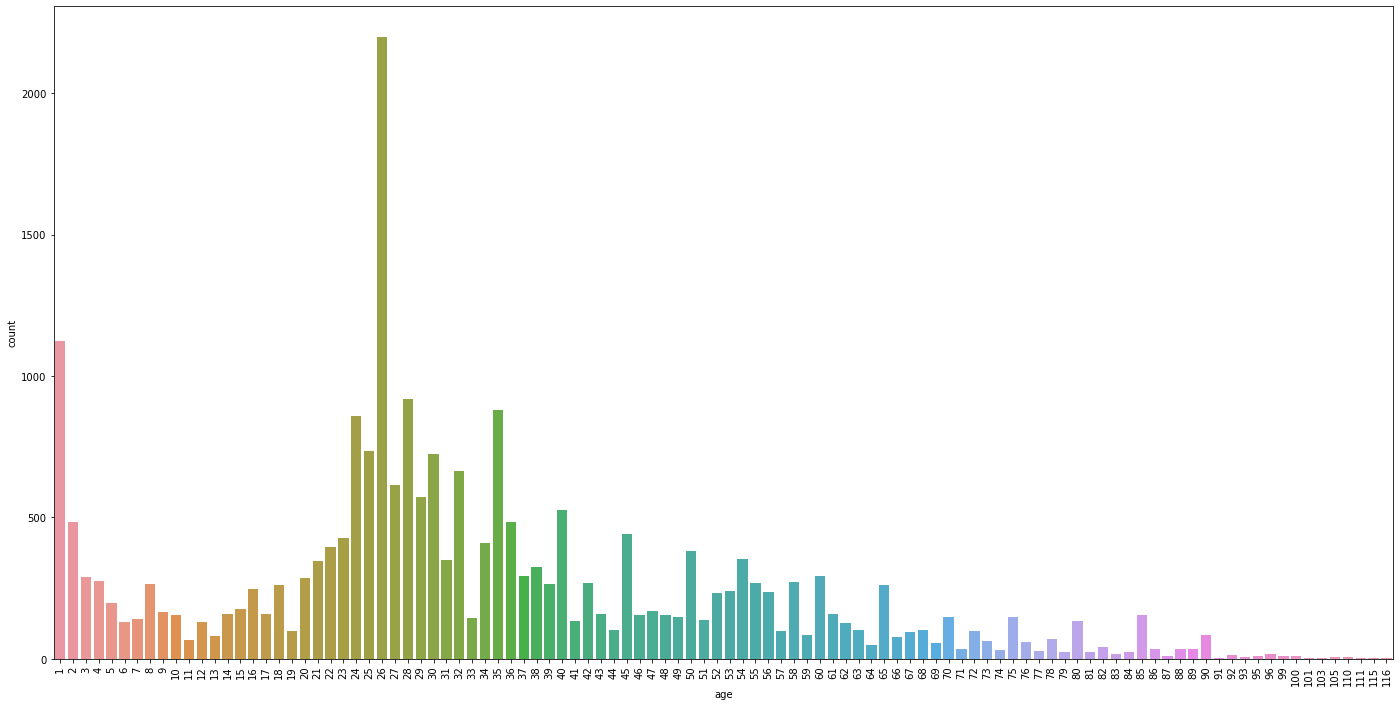

In [51]:
plt.figure(figsize=(24,12))
sns.set_palette("Paired")
sns.countplot(x ="age", data = mydata) 
plt.xticks(rotation=90)
plt.show()


As you see, there are also some problems for age data. "26" has too much example and "70" and beyond has too less. So, we should preprocess the data.

In [52]:
count_age=mydata[mydata["age"]==26]["age"].count()
len_age=len(mydata["age"])
print("There are {} labelled data for age 26 and length of age data is {}".format(count_age,len_age))

There are 2197 labelled data for age 26 and length of age data is 23705


## Data preprocessing

### Preprocessing gender data

In [53]:
x_gender= mydata.iloc[:,-1]

In [54]:
img_data_gender=[]

for i in x_gender:
    image=np.array(i.split(" "),dtype="float32")
    image=image.reshape(48,48,1)
    img_data_gender.append(image)
    
img_data_gender=np.array(img_data_gender)
img_data_gender/=255
img_data_gender= img_data_gender.reshape(img_data_gender.shape[0],48,48,1)


y_gender= np.array([i for i in mydata["gender"]],dtype="int")
y_gender= to_categorical(y_gender,2)

### Preprocessing ethnicity data

In [55]:
x_ethniticy=[]
y_ethniticy=[]
j=[0]

for i in range(len(mydata["ethnicity"])):
    if mydata["ethnicity"][i]==0:
        if j[0]<5000:
            j[0]+=1
            x_ethniticy.append(mydata["pixels"][i])
            y_ethniticy.append(mydata["ethnicity"][i])
            
    elif mydata["ethnicity"][i]==4:
        continue;

    else:
        x_ethniticy.append(mydata["pixels"][i])
        y_ethniticy.append(mydata["ethnicity"][i])
        

In [56]:
img_data_eth=[]

for i in x_ethniticy:
    image=np.array(i.split(" "),dtype="float32")
    image=image.reshape(48,48,1)
    img_data_eth.append(image)
    
img_data_eth=np.array(img_data_eth)
img_data_eth/=255
img_data_eth= img_data_eth.reshape(img_data_eth.shape[0],48,48,1)

y_ethniticy= np.array(y_ethniticy, dtype="int")
y_ethnicity= to_categorical(y_ethniticy)

<AxesSubplot:xlabel='ethnicity', ylabel='count'>

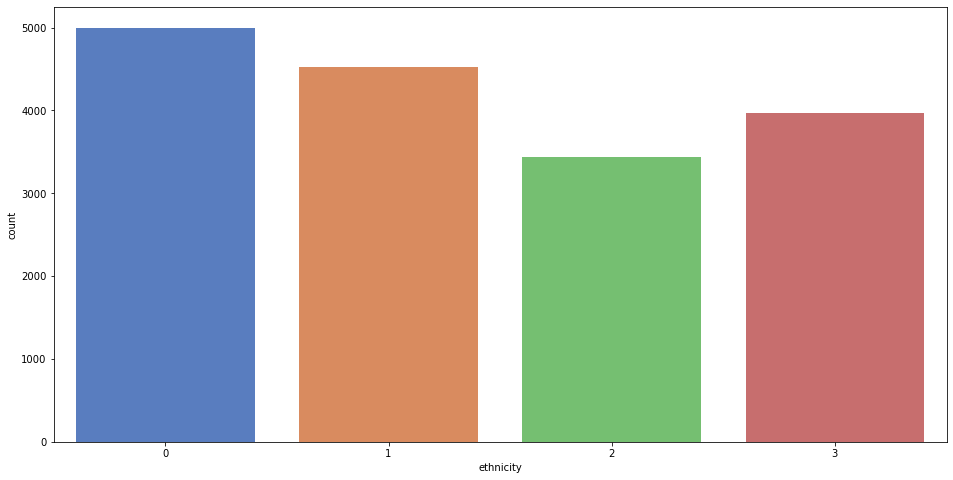

In [57]:
df_eth=pd.DataFrame(data=y_ethniticy, columns=["ethnicity"])
plt.figure(figsize=(16,8))
sns.set_palette("muted")
sns.countplot(x ='ethnicity', data = df_eth) 

### Preprocessing age data

In [58]:
x_age=[]
y_age=[]
j=0
for i in range(len(mydata["age"])):
    if mydata["age"][i]==26:
        if j<1200:
            j+=1
            x_age.append(mydata["pixels"][i])
            y_age.append(mydata["age"][i])
    elif mydata["age"][i]>70:
        continue
    else:
        x_age.append(mydata["pixels"][i])
        y_age.append(mydata["age"][i])
        

In [59]:
img_data_age=[]
for i in x_age:
    image=np.array(i.split(" "),dtype="float32")
    image=image.reshape(48,48,1)
    img_data_age.append(image)
    
img_data_age=np.array(img_data_age)
img_data_age/=255
img_data_age= img_data_age.reshape(img_data_age.shape[0],48,48,1)

y_age= np.array(y_age, dtype="int")

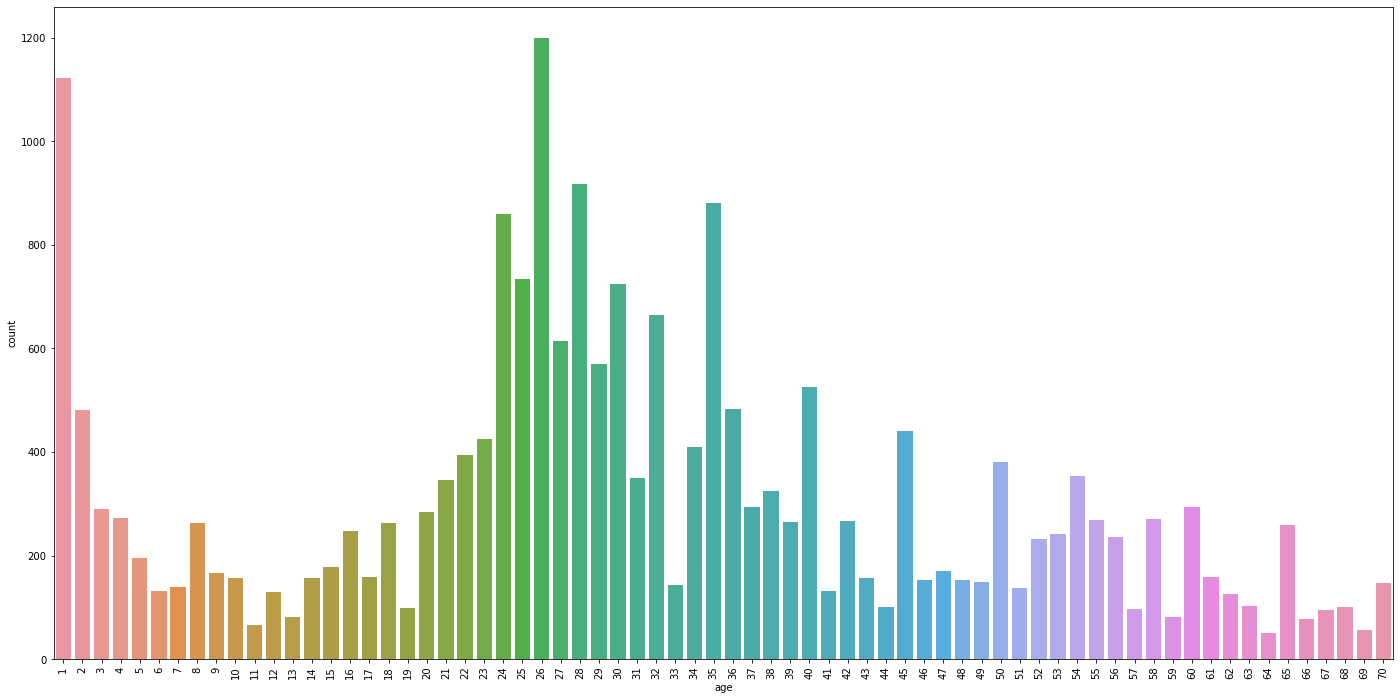

In [60]:
df_age=pd.DataFrame(data=y_age, columns=["age"])
plt.figure(figsize=(24,12))
sns.set_palette("Paired")
sns.countplot(x ='age', data = df_age) 
plt.xticks(rotation=90)
plt.show()

## Show random images

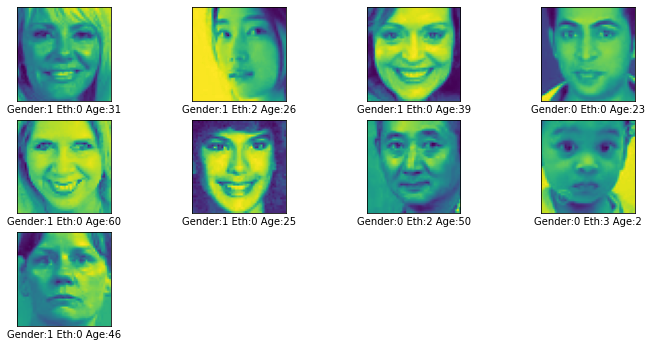

In [61]:
random_image=[random.randint(0,len(img_data_gender)) for i in range(10)]

w=10
h=10
fig=plt.figure(figsize=(12, 10))
columns = 4
rows = 5
for i in range(1, 10):
    image = img_data_gender[random_image[i]] 
    fig.add_subplot(rows, columns, i)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(image)
    plt.xlabel("Gender:"+str(mydata['gender'].iloc[random_image[i]])+" Eth:"+str(mydata['ethnicity'].iloc[random_image[i]])+" Age:"+str(mydata['age'].iloc[random_image[i]]))
plt.show()

## Split datas for training and testing

In [62]:
xtrain_gender, xtest_gender, ytrain_gender, ytest_gender= train_test_split(img_data_gender, y_gender, test_size=0.33, random_state=0)
xtrain_eth, xtest_eth, ytrain_eth, ytest_eth= train_test_split(img_data_eth, y_ethnicity, test_size=0.20, random_state=38)
xtrain_age, xtest_age, ytrain_age, ytest_age= train_test_split(img_data_age, y_age, test_size=0.33, random_state=38)


### Callback for models

In [63]:
stop_early= keras.callbacks.EarlyStopping(monitor="val_loss",patience=2)

## Define models

We use keras API and keras tuner.

In [64]:
def model_builder_gender(hp):
    image_input= keras.Input(shape=(48,48,1))
    x= Conv2D(32, kernel_size=3, activation="relu")(image_input)
    x= Conv2D(filters=64, kernel_size=3, activation="relu")(x)
    x= MaxPooling2D(2)(x)
    x= Dropout(0.30)(x)
    hp_kernel= hp.Choice("kernel_size", values=[3,5])
    x= Conv2D(128, kernel_size=hp_kernel, activation="relu")(x)
    x= MaxPooling2D(2)(x)
    x= BatchNormalization()(x)
    x= Flatten()(x)
    x= Dense(units=128, activation= "relu")(x)
    image_output= Dense(2,activation="softmax")(x)
    model= keras.Model(image_input, image_output)
    hp_learning_rate= hp.Choice("learning_rate", values=[1e-2,1e-3]);
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=keras.losses.CategoricalCrossentropy(from_logits=True),
                metrics=["accuracy"])
    return model

In [65]:
def model_builder_ethnicity(hp):
    image_input= keras.Input(shape=(48,48,1))
    x= Conv2D(16, kernel_size=5, activation="relu")(image_input)
    x= Conv2D(32, kernel_size=5, activation="relu")(x)
    x= Conv2D(64, kernel_size=5, activation="relu")(x)
    x= MaxPooling2D(pool_size=(2, 2))(x)
    x= Dropout(0.30)(x)
    x= Conv2D(96, kernel_size=3, activation="relu")(x)
    x= Conv2D(128, kernel_size=1, activation="relu")(x)
    x= MaxPooling2D(pool_size=(2, 2))(x)
    x= BatchNormalization()(x)
    x= Flatten()(x)
    hp_units= hp.Choice("units", values=[128,256])
    x= Dense(units=hp_units, activation= "relu")(x)
    image_output= Dense(4,activation="softmax")(x)
    model= keras.Model(image_input, image_output)
    hp_models= hp.Choice("model_type", values=["rmsprop","adam"])
    if hp_models=="rmsprop":
        model.compile(optimizer= keras.optimizers.Adam(learning_rate=1e-3),
                loss=keras.losses.CategoricalCrossentropy(),
                metrics=["accuracy"])
    else:
        model.compile(optimizer= keras.optimizers.RMSprop(learning_rate=1e-3),
                loss=keras.losses.CategoricalCrossentropy(),
                metrics=["accuracy"])
        
    return model

In [66]:
def model_builder_age(hp):
    image_input= keras.Input(shape=(48,48,1))
    x= Conv2D(16, kernel_size=3, activation="relu")(image_input)
    x= Conv2D(32, kernel_size=3, activation="relu")(x)
    x= MaxPooling2D(pool_size=(2, 2))(x)
    x= Dropout(0.30)(x)
    x= Conv2D(64, kernel_size=3, activation="relu")(x)
    x= Conv2D(96, kernel_size=3, activation="relu")(x)
    x= MaxPooling2D(pool_size=(2, 2))(x)
    x= Dropout(0.30)(x)
    x= Conv2D(128, kernel_size=3, activation="relu")(x)
    x= Conv2D(160, kernel_size=3, activation="relu")(x)
    x= BatchNormalization()(x)
    x= Flatten()(x)
    x= Dense(units=256, activation= "relu")(x)
    image_output= Dense(1)(x)
    model= keras.Model(image_input, image_output)
    hp_losses= hp.Choice("loss_type", values=["mean_absolute_percentage_error","mean_absolute_error"])
    if hp_losses=="mean_absolute_error":
        model.compile(optimizer= keras.optimizers.Adam(learning_rate=1e-3),
                loss= "mean_absolute_error",
                metrics=["mean_squared_error"])
    else:
        model.compile(optimizer= keras.optimizers.Adam(learning_rate=1e-2),
                loss= "mean_squared_error",
                metrics=["mean_squared_error"])
        
    return model

## Define tuners for each models

In [67]:
tuner_gender = kt.Hyperband(model_builder_gender,
                     objective='val_accuracy',
                     max_epochs=5,
                     factor=2,
                     directory='my_dir',
                     project_name='face_age_gender')

In [68]:
tuner_eth = kt.Hyperband(model_builder_ethnicity,
                     objective='val_accuracy',
                     max_epochs=5,
                     factor=3,
                     directory='my_dir',
                     project_name='face_age_ethnicity')

In [69]:
tuner_age = kt.Hyperband(model_builder_age,
                     objective='val_loss',
                     max_epochs=5,
                     factor=3,
                     directory='my_dir',
                     project_name='face_age_age')

## Searching best hyperparameters for each models with keras tuner

In [70]:
tuner_gender.search(xtrain_gender, ytrain_gender , epochs=5, validation_split=0.2, callbacks=[stop_early])
best_hps_gender=tuner_gender.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search for gender  is complete. The optimal kernel size for the third convolutional layer is {best_hps_gender.get('kernel_size')}.
the optimal learning rate for the optimizer is {best_hps_gender.get('learning_rate')}. """)

Trial 4 Complete [00h 02m 49s]
val_accuracy: 0.8445073962211609

Best val_accuracy So Far: 0.8681145906448364
Total elapsed time: 00h 13m 13s

The hyperparameter search for gender  is complete. The optimal kernel size for the third convolutional layer is 5.
the optimal learning rate for the optimizer is 0.001. 


In [71]:
tuner_eth.search(xtrain_eth, ytrain_eth , epochs=5, validation_split=0.2, callbacks=[stop_early])
best_hps_eth=tuner_eth.get_best_hyperparameters(num_trials=1)[0]

print(f""" The hyperparameter search for ethnicity is complete. The optimal units for the first dense layer is {best_hps_eth.get('units')}. 
The optimal optimizer is {best_hps_eth.get('model_type')}. """)


Trial 4 Complete [00h 03m 55s]
val_accuracy: 0.7313653230667114

Best val_accuracy So Far: 0.7494465112686157
Total elapsed time: 00h 15m 25s
 The hyperparameter search for ethnicity is complete. The optimal units for the first dense layer is 128. 
The optimal optimizer is rmsprop. 


In [72]:
tuner_age.search(xtrain_age, ytrain_age , epochs=5, validation_split=0.2, callbacks=[stop_early])
best_hps_age=tuner_age.get_best_hyperparameters(num_trials=1)[0]

print(f"""The hyperparameter search for age is complete. The best loss type is {best_hps_age.get('loss_type')}. """)


The hyperparameter search for age is complete. The best loss type is mean_absolute_error. 


## Find optimal epoch number for each models

In [74]:
model_gender= tuner_gender.hypermodel.build(best_hps_gender)
history_gender= model_gender.fit(xtrain_gender, ytrain_gender, epochs=10, validation_split= 0.2)

val_accuracy_per_epoch_gender=history_gender.history["val_accuracy"]
best_epoch_gender= val_accuracy_per_epoch_gender.index(max(val_accuracy_per_epoch_gender))+1

print('Best epoch for gender: %d' % (best_epoch_gender,))

Epoch 1/10
398/398 [==============================] - 113s 284ms/step - loss: 0.5811 - accuracy: 0.7352 - val_loss: 0.4139 - val_accuracy: 0.8448
Epoch 2/10
398/398 [==============================] - 113s 283ms/step - loss: 0.3163 - accuracy: 0.8593 - val_loss: 0.2923 - val_accuracy: 0.8719
Epoch 3/10
398/398 [==============================] - 113s 284ms/step - loss: 0.2738 - accuracy: 0.8842 - val_loss: 0.3110 - val_accuracy: 0.8697
Epoch 4/10
398/398 [==============================] - 113s 284ms/step - loss: 0.2338 - accuracy: 0.8996 - val_loss: 0.3098 - val_accuracy: 0.8738
Epoch 5/10
398/398 [==============================] - 113s 285ms/step - loss: 0.1916 - accuracy: 0.9195 - val_loss: 0.2839 - val_accuracy: 0.8842
Epoch 6/10
398/398 [==============================] - 113s 285ms/step - loss: 0.1795 - accuracy: 0.9285 - val_loss: 0.2701 - val_accuracy: 0.9018
Epoch 7/10
398/398 [==============================] - 113s 284ms/step - loss: 0.1475 - accuracy: 0.9413 - val_loss: 0.2833 -

In [76]:
model_eth= tuner_eth.hypermodel.build(best_hps_eth)
history_eth= model_eth.fit(xtrain_eth, ytrain_eth, epochs=10, validation_split= 0.2)

val_accuracy_per_epoch_eth=history_eth.history["val_accuracy"]
best_epoch_eth= val_accuracy_per_epoch_eth.index(max(val_accuracy_per_epoch_eth))+1

print('Best epoch for ethnicity: %d' % (best_epoch_eth,))

Epoch 1/10
339/339 [==============================] - 113s 330ms/step - loss: 1.0181 - accuracy: 0.5814 - val_loss: 1.2355 - val_accuracy: 0.3620
Epoch 2/10
339/339 [==============================] - 113s 332ms/step - loss: 0.6662 - accuracy: 0.7437 - val_loss: 0.7622 - val_accuracy: 0.7196
Epoch 3/10
339/339 [==============================] - 112s 330ms/step - loss: 0.5725 - accuracy: 0.7850 - val_loss: 0.5544 - val_accuracy: 0.7952
Epoch 4/10
339/339 [==============================] - 113s 335ms/step - loss: 0.4741 - accuracy: 0.8212 - val_loss: 0.6647 - val_accuracy: 0.7690
Epoch 5/10
339/339 [==============================] - 118s 348ms/step - loss: 0.4274 - accuracy: 0.8400 - val_loss: 0.5609 - val_accuracy: 0.7985
Epoch 6/10
339/339 [==============================] - 112s 332ms/step - loss: 0.3657 - accuracy: 0.8649 - val_loss: 0.5969 - val_accuracy: 0.7911
Epoch 7/10
339/339 [==============================] - 112s 329ms/step - loss: 0.3022 - accuracy: 0.8865 - val_loss: 0.5972 -

In [77]:
model_age= tuner_age.hypermodel.build(best_hps_age)
history_age= model_age.fit(xtrain_age, ytrain_age, epochs=10, validation_split= 0.2)

val_loss_per_epoch_age=history_age.history["val_loss"]
best_epoch_age= val_loss_per_epoch_age.index(max(val_loss_per_epoch_age))+1

print('Best epoch for age: %d' % (best_epoch_age,))

Epoch 1/10
360/360 [==============================] - 58s 161ms/step - loss: 13.9201 - mean_squared_error: 336.2315 - val_loss: 11.6955 - val_mean_squared_error: 248.3977
Epoch 2/10
360/360 [==============================] - 58s 160ms/step - loss: 9.0255 - mean_squared_error: 145.1936 - val_loss: 8.9382 - val_mean_squared_error: 149.2779
Epoch 3/10
360/360 [==============================] - 58s 161ms/step - loss: 8.4846 - mean_squared_error: 132.4351 - val_loss: 9.5335 - val_mean_squared_error: 186.4602
Epoch 4/10
360/360 [==============================] - 58s 161ms/step - loss: 7.9544 - mean_squared_error: 118.0834 - val_loss: 8.2215 - val_mean_squared_error: 132.3055
Epoch 5/10
360/360 [==============================] - 58s 160ms/step - loss: 7.4969 - mean_squared_error: 106.4574 - val_loss: 7.0219 - val_mean_squared_error: 91.6857
Epoch 6/10
360/360 [==============================] - 57s 160ms/step - loss: 7.0615 - mean_squared_error: 92.6424 - val_loss: 10.6680 - val_mean_squared_e

## Train and test models

In [78]:
hypermodel_gender = tuner_gender.hypermodel.build(best_hps_gender)
hypermodel_gender.fit(xtest_gender, ytest_gender, epochs=best_epoch_gender)

NameError: name 'best_hps' is not defined

In [ ]:
eval_result_gender = hypermodel_gender.evaluate(xtest_gender, ytest_gender)

In [ ]:
hypermodel_eth = tuner_eth.hypermodel.build(best_hps_eth)
hypermodel_eth.fit(xtest_eth, ytest_eth, epochs=best_epoch_eth)

In [ ]:
eval_result_eth = hypermodel_eth.evaluate(xtest_eth, ytest_eth)

In [ ]:
hypermodel_age = tuner_age.hypermodel.build(best_hps_age)
hypermodel_age.fit(xtest_age, ytest_age, epochs=best_epoch_age)

In [ ]:
eval_result_age = hypermodel_age.evaluate(xtest_age, ytest_age)

## Validation results

In [ ]:
print("[test loss gender, test accuracy gender]:", eval_result_gender)
print("[test loss for ethnicity, test accuracy for ethnicity]:", eval_result_eth)
print("[test loss for age, test accuracy for age]:", eval_result_age)

## Results

In [ ]:
print(history_gender.history.keys())
print(history_eth.history.keys())
print(history_age.history.keys())

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(history_gender.history['accuracy'], label='accuracy')
plt.plot(history_gender.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(history_gender.history['loss'])
plt.plot(history_gender.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train_loss', 'val_loss'], loc='lower left')
plt.show()

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(history_eth.history['accuracy'], label='accuracy')
plt.plot(history_eth.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(history_eth.history['loss'])
plt.plot(history_eth.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train_loss', 'val_loss'], loc='lower left')
plt.show()

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(history_age.history['loss'], label='mse')
plt.plot(history_age.history['val_loss'], label = 'mean_squared_error')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.legend(loc='lower right')

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(history_age.history['mean_squared_error'], label='mse')
plt.plot(history_age.history['val_mean_squared_error'], label = 'mean_squared_error')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.legend(loc='lower right')